# Flight Delay Analysis

This notebook analyses the flight delay data from January 2016, obtained from [here](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). In the second part of this report, a machine learning model is constructed to predict flight cancellations from January-March 2016.
No flight data was sanitized beforehand. 

In [1]:
# Load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import seaborn as sns
%matplotlib inline

import matplotlib.style
matplotlib.style.use('ggplot')

## Loading and cleaning the data
The raw flight data contains some missing and wrong-formatted data which has to be cleaned up first.

The `carriers.xlt` and `airports new.xls` were cleaned up beforehand since they contained a lot of empty rows / text formatted as numerics, but are mostly static and not obtained dynamically from the data warehouse.
For easy processing by Pandas, they were converted to CSV as well.

In [45]:
# Read carriers to an easy dictionary (for fast lookup)
carriers_dict = pd.Series.from_csv('carriers.csv').to_dict()

# Read flights
flights = pd.read_csv('january_2016.csv')

# Read airports
airports = pd.read_csv('airports new2.csv')

# Join flights with airport data
airports.set_index('iata')
airports_from = airports.copy()
airports_from.columns = airports_from.columns.map(lambda x: 'origin_' + str(x))
flights = pd.merge(flights, airports_from, how='inner', left_on='ORIGIN', right_on='origin_iata')
airports_to = airports.copy()
airports_to.columns = airports.columns.map(lambda x: 'dest_' + str(x))
flights = pd.merge(flights, airports_to, how='inner', left_on='DEST', right_on='dest_iata')

# Clean date
flights['FL_DATE']= pd.to_datetime(flights['FL_DATE'], infer_datetime_format=True)

# Replace NaN delays (no delay) with 0
delay_types = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
flights[delay_types] = flights[delay_types].fillna(0)

# Create a cancelled and uncancelled list
c_flights = flights[flights.CANCELLED == 1]
uc_flights = flights[flights.CANCELLED == 0]

# Check the data
num_flights, _ = uc_flights.shape
print("%d flights loaded" % num_flights)
uc_flights.head(5)

433453 flights loaded


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,...,origin_country,origin_lat,origin_long,dest_iata,dest_airport,dest_city,dest_state,dest_country,dest_lat,dest_long
0,1,28,4,2016-01-28,UA,N76514,604,PHX,DEN,943,...,USA,33.434167,-112.008056,DEN,Denver Intl,Denver,CO,USA,39.858408,-104.667002
1,1,28,4,2016-01-28,UA,N451UA,792,PHX,DEN,1846,...,USA,33.434167,-112.008056,DEN,Denver Intl,Denver,CO,USA,39.858408,-104.667002
2,1,28,4,2016-01-28,UA,N492UA,1185,PHX,DEN,1056,...,USA,33.434167,-112.008056,DEN,Denver Intl,Denver,CO,USA,39.858408,-104.667002
3,1,26,2,2016-01-26,UA,N76254,489,PHX,DEN,700,...,USA,33.434167,-112.008056,DEN,Denver Intl,Denver,CO,USA,39.858408,-104.667002
4,1,26,2,2016-01-26,UA,N38443,604,PHX,DEN,938,...,USA,33.434167,-112.008056,DEN,Denver Intl,Denver,CO,USA,39.858408,-104.667002


## Initial exploration

Getting a broader view of the data might give a first indicator about the quality of the dataset.

**Q.** Which carrier is the most reliable in terms of cancellations?

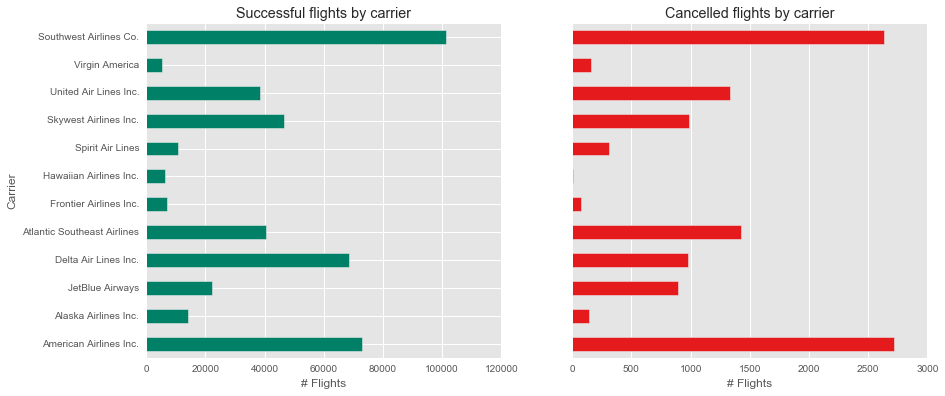

In [3]:
flights_by_carrier = uc_flights.groupby(by=['CARRIER']).size().rename(carriers_dict)
cancelled_flights_by_carrier = c_flights.groupby(by=['CARRIER']).size().rename(carriers_dict)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax1 = flights_by_carrier.plot(kind='barh', title='Successful flights by carrier', ax=axes[0], colormap='summer')
ax1.set_xlabel("# Flights")
ax1.set_ylabel("Carrier")

ax2 = cancelled_flights_by_carrier.plot(kind='barh', title='Cancelled flights by carrier', ax=axes[1], colormap='Set1')
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel("# Flights")

From these results we can already see that `American Airlines Inc.` and `Southwest Airlines Co.` have the most flight cancellations, but this was to be expected since they are also the largest carriers of the US. A more interesting metric is the cancelled flights per total flights served.

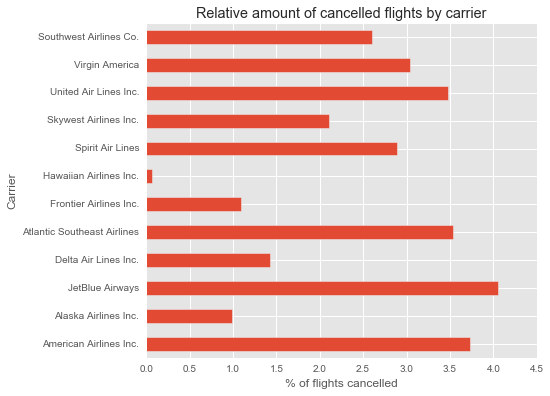

In [4]:

ax = ((cancelled_flights_by_carrier / flights_by_carrier) * 100).plot(kind='barh', \
                                                                      title='Relative amount of cancelled flights by carrier',
                                                                         figsize=(7, 6))
ax.set_ylabel("Carrier")
ax.set_xlabel("% of flights cancelled")

**A.** The most reliable carrier in the US is `Hawaiian Airlines Inc.`, with `Alaska Airlines` second place. An interesting find, since the latter most likely has to cope with harder weather conditions in January. `JetBlue` performs the worst in terms of cancellations. We'll invest this further.

## Cancellation reasons

**Q.** What is the most common reason flights get cancelled, and which carrier is the worst in terms of cancellations due to internal organisation instead of unexpected circumstances?

In [5]:
# Verify if there is missing data
print("Number of missing reasons: %d" % c_flights[c_flights['CANCELLATION_CODE'] == ''].shape[0])
c_flights[['CARRIER', 'CANCELLATION_CODE']].groupby(by=['CARRIER', 'CANCELLATION_CODE']).size()


Number of missing reasons: 0


CARRIER  CANCELLATION_CODE
AA       A                     232
         B                    2440
         C                      48
AS       A                      52
         B                      82
         C                       5
B6       A                      65
         B                     807
         C                      25
DL       A                      55
         B                     909
         C                      10
EV       A                     262
         B                     614
         C                     551
F9       A                       5
         B                      72
HA       A                       2
         B                       2
NK       A                      52
         B                     232
         C                      24
OO       A                     126
         B                     766
         C                      92
UA       A                      96
         B                    1119
         C                  

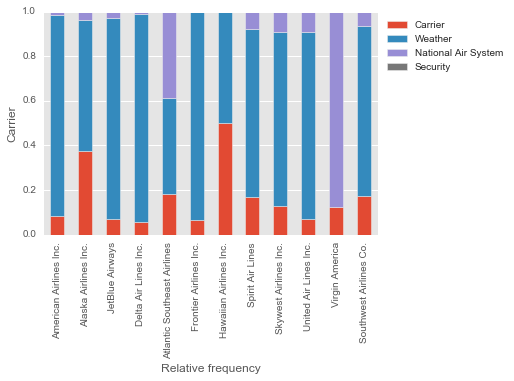

In [6]:
cancellation_reasons = {
    'A' : 'Carrier',
    'B' : 'Weather',
    'C' : 'National Air System',
    'D' : 'Security'
}

cancelled_by_carrier = c_flights[['CARRIER', 'CANCELLATION_CODE']].groupby(by=['CARRIER'])
cancelled_df = pd.DataFrame(columns=('carrier', 'A', 'B', 'C', 'D'))
for i, v in cancelled_by_carrier:
    row = {'carrier': i, 'A': 0, 'B': 0, 'C': 0, 'D': 0}
    total = 0
    for k, n in v.groupby(by='CANCELLATION_CODE').size().iteritems():
        row[k] = n
        total += n
    for t in cancellation_reasons.keys():
        row[t] /= total
    cancelled_df = cancelled_df.append(row, ignore_index=True)

cancelled_df['carrier'] = cancelled_df['carrier'].map(carriers_dict)
ax = cancelled_df.plot(kind='bar', stacked=True, use_index=False, xticks=cancelled_df.index)
ax.set_xticklabels(cancelled_df['carrier'])
ax.set_xlabel("Relative frequency")
ax.set_ylabel("Carrier")
ax.legend([cancellation_reasons[x] for x in sorted(cancellation_reasons)], bbox_to_anchor=(1.4, 1))

**A.** The most reliable airliner is `Delta Airlines`, of which only 5.6% of the cancellations are due to the carrier itself, with `JetBlue` second place. At first glance this looks like it contradicts the previous observation, where `JetBlue` was the worst performer, but this is due to their focus on North-America, where weather conditions are worse than south.

Due to the sparsity of `Hawaiian Airlines Inc.` data (only 2 cancellations per set), no conclusions can be made.

Luckily, no flight was cancelled due to security reasons in January 2016.

## Cancellation conclusion
`Hawaiian Airlines Inc.` was the most reliable airliner in January 2016 in terms of cancellations. Most of the flights were cancelled due to weather conditions or the national air system.

## Departure and Arrival delays
Another reason one would choose a certain airliner over another is flight delay. Flights that depart or arrive before schedule are perceived as good. Higher arrival and depart delays are perceived bad.

**Q.** How many flights arrive on time or earlier?

In [7]:
flights_to_check = uc_flights[(uc_flights['DEP_DELAY'].notnull() & uc_flights['ARR_DELAY'].notnull())]
delay_columns = {'DEP_DELAY': 'Departure', 'ARR_DELAY': 'Arrival'}
flights_to_check[['DEP_DELAY', 'ARR_DELAY']].describe()

,DEP_DELAY,ARR_DELAY
count,432590.000000,432590.000000
mean,7.763873,1.538852
std,36.745920,39.110241
min,-47.000000,-79.000000
25%,-5.000000,-15.000000
50%,-2.000000,-7.000000
75%,5.000000,5.000000
max,1663.000000,1659.000000


**A.** From this overall data we can see that more than half of the planes arrive earlier than their scheduled arrival time. Moreover, more than half of the planes leave the airport before their scheduled departure time. From the 50% percentiles, we can see that even more time is is compensated during flight.

**Q.** Which airliner has on average the most / least departure delays per flight? What are the most common reasons?

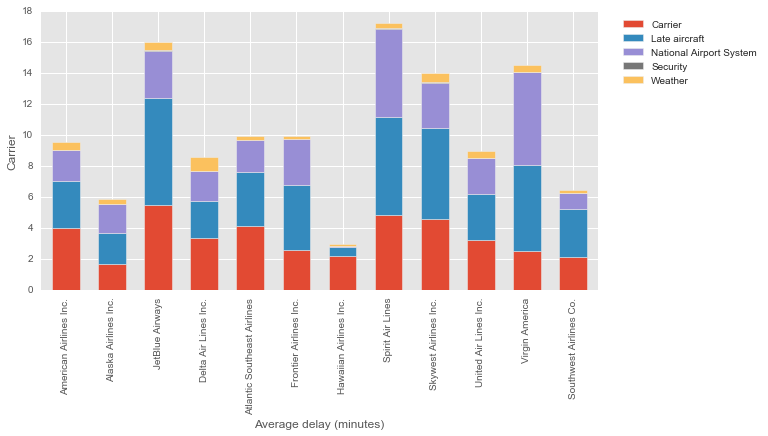

In [8]:
delay_types = {'CARRIER_DELAY': 'Carrier',
               'NAS_DELAY': 'National Airport System',
               'WEATHER_DELAY': 'Weather',
               'SECURITY_DELAY': 'Security',
               'LATE_AIRCRAFT_DELAY': 'Late aircraft'}

flight_delays = uc_flights[['CARRIER'] + sorted(delay_types.keys())].groupby(by=['CARRIER']).agg('mean')
labels = [carriers_dict[x] for x in sorted(flights_to_check['CARRIER'].unique())]
ax = flight_delays.plot(kind='bar', stacked=True, figsize=(10,5), width=0.6)
ax.legend([delay_types[t] for t in sorted(delay_types.keys())], bbox_to_anchor=(1.3, 1));
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Average delay (minutes)')
ax.set_ylabel('Carrier')

**A.** Again, `Hawaiian Airlines Inc.` is the clear winner, with an average delay of only 3 minutes. From these results it becomes apparent that it has less problems with *late aircrafts* compared to their competition. 

`Spirit Air Lines` has the highest departure delays. If they want to improve their service, they can compensate by lowering their *late aircraft delays* (by e.g. using more planes) and internal restructuring reducing the *carrier delays*.

**Side Q.** Why does `Hawaiian Airlines Inc.` have the lowest *national airport system delays*?

Let's investigate! We take all the airports where `Hawaiian Airlines Inc.` takes off.

Average departure delay: 7.784062


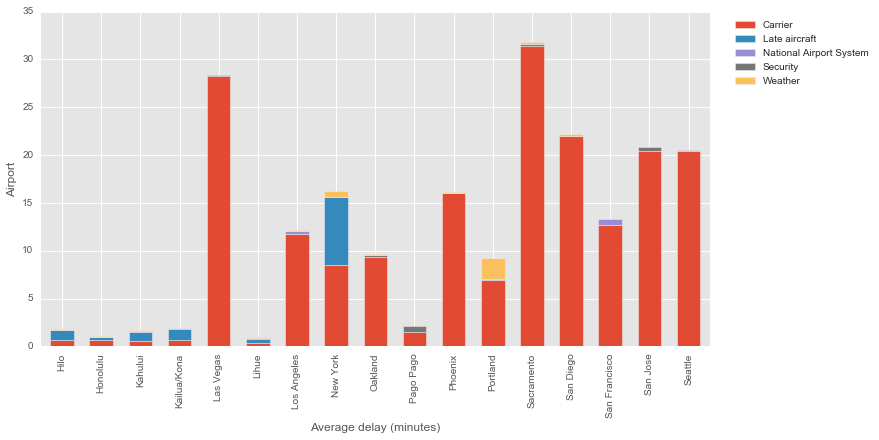

In [9]:
print("Average departure delay: %f" % uc_flights['DEP_DELAY'].mean())

hawaii_flights = uc_flights[uc_flights['CARRIER'] == 'HA']
reasons = [delay_types[t] for t in sorted(delay_types.keys())]
hawaii_airlines_delays = hawaii_flights[['origin_city'] + sorted(delay_types.keys())].groupby(by=['origin_city']).agg('mean')

ax = hawaii_airlines_delays.plot(kind='bar', stacked=True, width=0.6, figsize=(12,6))
ax.legend(reasons, bbox_to_anchor=(1.25, 1));
ax.set_xlabel('Average delay (minutes)')
ax.set_ylabel('Airport')

**A.** Apparently the cooperation between `Hawaiian Airlines Inc.` and their local airport system works quite well. All departure delays on the island are the lowest of them all, **but** *we see that there are quite high delays when departing from the US mainland.* The delays on mainland are much higher compared to the average delay of 7.77 minutes. There seems room for improvement by optimizing cooperation between `Hawaiian Airlines Inc.` and the airports from the other states.

**Q.** What is the most common departure delay, how is it distributed?

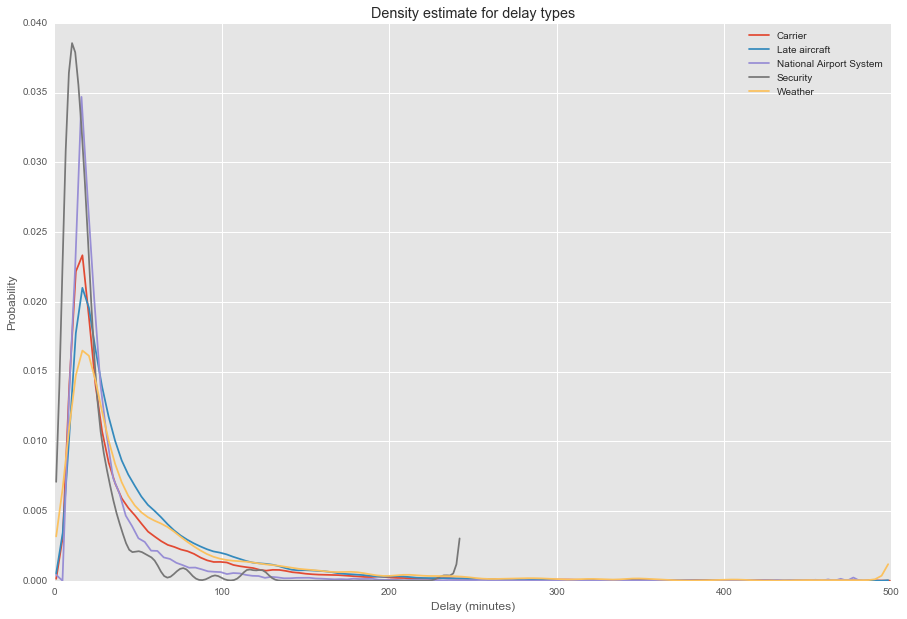

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(15,10))
    for d_type in sorted(delay_types.keys()):
        ax = sns.kdeplot(data=uc_flights[uc_flights[d_type] > 0][d_type], clip=(0,500), cut=0)
sns.plt.title('Density estimate for delay types')
plt.legend([delay_types[t] for t in sorted(delay_types.keys())]);
ax.set(xlabel='Delay (minutes)', ylabel='Probability')

**A.** From these results we see that most of the delays are of short narture. Security delays are most often of smaller periods compared to weather, late aircrafts, carrier or NAS conditions.

**Q.** Are there higher weather delays for airports situated closer to the North?

We can analyze this by observing the latitude of the departure airports with relation to the weather departure delay.

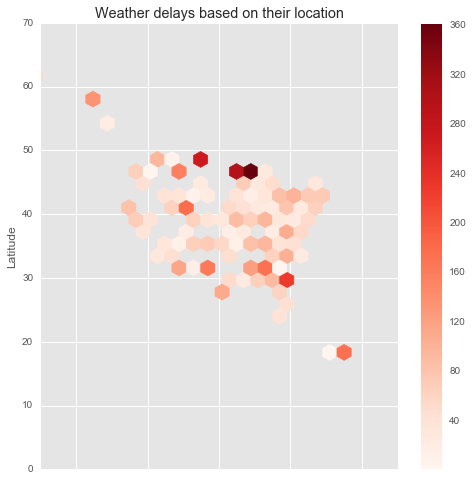

In [11]:
filtered = uc_flights[uc_flights['WEATHER_DELAY'] > 0][['origin_lat', 'origin_long', 'WEATHER_DELAY']].copy()
ax = filtered.plot.hexbin(y='origin_lat', x='origin_long', 
                          C='WEATHER_DELAY', reduce_C_function=np.mean,
                          gridsize=25, figsize=(8, 8),
                         cmap='Reds')
plt.axis([-150, -50, 0, 70])
plt.xlabel('Longtitude')  # Bug in Pandas does not plot this label: https://github.com/ipython/ipython/issues/8653
plt.ylabel('Latitude')
plt.title('Weather delays based on their location')

**A.** We can observe that there are indeed higher delays for the more northern regions, compared to their more southern regions. The highest weather delays are caused between 40 and 50 degrees latitude.

# Machine learning: predicting flight cancellations

## Feature extraction
Based on the previous analysis, we'll construct a model predicting whether a flight was cancelled in January-March 2016.
First we'll test some basic feature extraction and then evaluate which features are important for our model.

**Note:** For the airports, carriers, day of month, ... a one-hot encoding should be used, since it is not continous data. When using them directly as input features, the classifier will try to fit them incorrectly.

### Prepare hot encoding

In [170]:
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import random

def convert_to_hot_dict(v):
    return [{str(x): str(x)} for x in v]

def prepare_hot_encoders(carriers, airports):
    carrier_vec = DictVectorizer(sparse = False)
    airports_vec = DictVectorizer(sparse = False)
    carrier_vec.fit_transform(convert_to_hot_dict(carriers))
    airports_vec.fit_transform(convert_to_hot_dict(airports))
    return carrier_vec, airports_vec

### Prepare feature loading / preprocessing

In [171]:
def load_dataset(df, carrier_encoder, airport_encoder, features, hot_features, airport_data_path='airports new2.csv',
                 include_carrier=False, include_airport=False):
    carrier_hot_len = len(carrier_encoder.feature_names_)
    airport_hot_len = len(airport_encoder.feature_names_)
    
    raw_data = df.dropna(subset=['CANCELLED'])
    
    print("# cancelled flights: %d" %  raw_data[raw_data['CANCELLED'] == 1].shape[0])
    print("# uncancelled flights: %d" %  raw_data[raw_data['CANCELLED'] == 0].shape[0])
        
    # Join with airport data
    airports_data = pd.read_csv(airport_data_path)
    raw_data = pd.merge(raw_data, airports_data, how='inner', left_on='ORIGIN', right_on='iata')
    
    # Convert hour to readable format
    raw_data['HOUR_DEP'] = raw_data['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[0:2]))
    raw_data['HOUR_ARR'] = raw_data['CRS_ARR_TIME'].map(lambda x: int(str(int(x)).zfill(4)[0:2]))
        
    (n, _) = raw_data.shape
    print("Loading %d items..." % n)
    
    simple_feature_len = len(features)
    
    # Calculate hot encodes
    simple_hot_len = 0
    simple_hot = None
    if len(hot_features) > 0:
        simple_hot = OneHotEncoder()
        simple_hot.fit(raw_data[hot_features])
        simple_hot_len = sum(simple_hot.n_values_) - len(simple_hot.n_values_)
    
    total_feature_count = simple_feature_len + simple_hot_len
    actual_carrier_len = (0 if not include_carrier else carrier_hot_len)
    actual_airport_len = (0 if not include_airport else airport_hot_len)
    #x = np.zeros((n, extra_feature_count + hot_encoded_count)) # carrier and twice airport (from-to)
    x = np.zeros((n, total_feature_count + actual_carrier_len + actual_airport_len))
    
    print("Extracting features...")
    x[:,0:simple_feature_len] = raw_data[features].as_matrix()
    
    # Hot encoding for columns
    if len(hot_features) > 0:
        transformed_hots = simple_hot.transform(raw_data[hot_features].as_matrix()).toarray()
        x[:,simple_feature_len:simple_feature_len+simple_hot_len] = transformed_hots.reshape((-1, simple_hot_len))
        
    # Hot encoded airports / carrier
    if include_carrier:
        x[:, total_feature_count:total_feature_count+actual_carrier_len] = carrier_encoder.transform(
            convert_to_hot_dict(raw_data['CARRIER']))
    if include_airport:
        x[:, total_feature_count+actual_carrier_len:total_feature_count + actual_carrier_len + actual_airport_len] \
                = airport_encoder.transform(convert_to_hot_dict(raw_data['DEST']))
    
    y = raw_data['CANCELLED'].as_matrix()
    return x, y
    
carrier_list = flights['CARRIER'].unique()
airport_list = pd.concat([flights['ORIGIN'], flights['DEST']], axis=0).unique()
carrier_encoder, airport_encoder = prepare_hot_encoders(carrier_list, airport_list)

def load_multiple_dataset(paths, carrier_encoder, airport_encoder, features, hot_features, include_airport, include_carrier):
    print('Loading entire dataset...')
    dfs = [pd.read_csv(p) for p in paths]
    total_df = pd.concat(dfs)
    return load_dataset(total_df, carrier_encoder, airport_encoder,features=features,
                        hot_features=hot_features, include_airport=include_airport, include_carrier=include_carrier)

First we try with only basic continuous features and no airport or carriers. Data is loaded from:
- January 2016
- February 2016
- March 2016

In [172]:
simple_copy_features = ['HOUR_DEP', 'HOUR_ARR', 'DISTANCE', 'lat', 'long', ]
simple_hot_features = []

# Load 3 months
X, y = load_multiple_dataset(['january_2016.csv', 'february_2016.csv', 'march_2016.csv'],
                             carrier_encoder, airport_encoder,
                             features=simple_copy_features,
                             hot_features=simple_hot_features,
                            include_airport=False,
                            include_carrier=False)
print('Finished all feature extraction.')

Loading entire dataset...
# cancelled flights: 23221
# uncancelled flights: 1325617
Loading 1347708 items...
Extracting features...
Finished all feature extraction.


We first evaluate our initial set of features importances using a quick tree classifier.

In [173]:
from sklearn.ensemble import ExtraTreesClassifier
feat_clf = ExtraTreesClassifier()
feat_clf = feat_clf.fit(X, y)
print(feat_clf.feature_importances_ )

[ 0.12032046  0.12946606  0.45090413  0.13586965  0.16343969]


From these results we can see that `DISTANCE` is the most important feature in the current feature set, but the other ones aren't neglegible as well.

## Training the model
Now the dataset is split into a test set (40%), validation and training set. The validation set will be used to evaluate our model and optimize hyperparameters. As a first classifier, Logistic Regression is used since it is fast and can process a lot of data (compared to SVMs).

In [127]:
from sklearn import cross_validation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn import linear_model
from sklearn import svm

# Create test and training set
X_train_set, X_test, y_train_set, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

# Create validation set from training set
X_train, X_val, y_train, y_val= cross_validation.train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=0)

# Divide the data into classes and then make sure there's an equal amount in both of them
def balance_set(xvals, yvals):
    cancelled_indices = yvals != 0
    uncancelled_indices =  yvals == 0
    cancelled_flights = yvals[cancelled_indices]
    uncancelled_flights = yvals[uncancelled_indices]
    max_balanced_flights = min(cancelled_flights.shape[0], uncancelled_flights.shape[0])

    cancelled_permutations = list(range(cancelled_flights.shape[0]))
    uncancelled_permutations = list(range(uncancelled_flights.shape[0]))
    random.shuffle(cancelled_permutations)
    random.shuffle(uncancelled_permutations)
    cancelled_selected_indices = cancelled_permutations[:max_balanced_flights]
    uncancelled_selected_indices = uncancelled_permutations[:max_balanced_flights]
    
    y_cancelled, x_cancelled = cancelled_flights[cancelled_selected_indices], \
                    xvals[cancelled_indices][cancelled_selected_indices]
    y_uncancelled, x_uncancelled = uncancelled_flights[uncancelled_selected_indices],  \
                    xvals[uncancelled_indices][uncancelled_selected_indices]

    xvals = np.concatenate([x_cancelled, x_uncancelled])
    yvals =  np.concatenate([y_cancelled, y_uncancelled])
    return xvals, yvals

X_train_b, y_train_b = balance_set(X_train, y_train)
X_val_b, y_val_b = balance_set(X_val, y_val)
    
print("Samples with cancelled: %d" % y_train_b[y_train_b != 0].shape[0])
print("Samples with non-cancelled: %d" % y_train_b[y_train_b == 0].shape[0])

clf = linear_model.LogisticRegression(penalty='l2', class_weight='balanced')
print('Training...')
clf.fit(X_train_b, y_train_b)

# Train info:
print('Predicting...')
train_pred = clf.predict(X_train_b)
print("\nTrain acc: %0.2f%%" % accuracy_score(y_train_b, train_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train_b, train_pred))

# Validation info:
val_pred = clf.predict(X_val_b)
rep = precision_recall_fscore_support(y_val_b, val_pred, average='binary')
print('\nValidation results:\nPrecision = %0.2f\nRecall = %0.2f\nF1 = %0.2f\nAccuracy = %0.2f\n' % (rep[0], rep[1], rep[2], accuracy_score(y_val_b, val_pred)))

Samples with cancelled: 10992
Samples with non-cancelled: 10992
Training...
Predicting...

Train acc: 0.59%
Confusion matrix:
[[6272 4720]
 [4304 6688]]

Validation results:
Precision = 0.58
Recall = 0.61
F1 = 0.60
Accuracy = 0.59



## Hot-encoding discrete input data
As we can see, the basic model from above does not perform very well, with an accuracy of only 59%.
Let's add non-continuous features as well, such as airports, carrier month, day of month and day of week.

In [144]:
simple_copy_features = ['HOUR_DEP', 'HOUR_ARR', 'DISTANCE', 'lat', 'long']
simple_hot_features = ['DAY_OF_WEEK', 'DAY_OF_MONTH', 'MONTH']

for incl_airport, incl_carrier in [(a, b) for a in [False, True] for b in [False, True]]:
    X, y = load_multiple_dataset(['january_2016.csv', 'february_2016.csv', 'march_2016.csv'],
                                 carrier_encoder, airport_encoder,
                                 features=simple_copy_features,
                                 hot_features=simple_hot_features,
                                include_airport=incl_airport,
                                include_carrier=incl_carrier)

    # Create test and training set
    X_train_set, X_test, y_train_set, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)
    X_train, X_val, y_train, y_val= cross_validation.train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=0)

    X_train_b, y_train_b = balance_set(X_train, y_train)
    X_val_b, y_val_b = balance_set(X_val, y_val)
    clf = linear_model.LogisticRegression(penalty='l2', class_weight='balanced')
    print('Training incl_airport: %d, inclu_carrier: %d' % (incl_airport, incl_carrier))
    clf.fit(X_train_b, y_train_b)

    # Validation info:
    val_pred = clf.predict(X_val_b)
    rep = precision_recall_fscore_support(y_val_b, val_pred, average='binary')
    print('\nValidation results:\nPrecision = %0.2f\nRecall = %0.2f\nF1 = %0.2f\nAccuracy = %0.2f\n' % (rep[0], rep[1], rep[2], accuracy_score(y_val_b, val_pred)))

Loading entire dataset...
# cancelled flights: 23221
# uncancelled flights: 1325617
Loading 1347708 items...
Extracting features...
Training incl_airport: 0, inclu_carrier: 0

Validation results:
Precision = 0.77
Recall = 0.70
F1 = 0.74
Accuracy = 0.75

Loading entire dataset...
# cancelled flights: 23221
# uncancelled flights: 1325617
Loading 1347708 items...
Extracting features...
Training incl_airport: 0, inclu_carrier: 1

Validation results:
Precision = 0.75
Recall = 0.74
F1 = 0.74
Accuracy = 0.75

Loading entire dataset...
# cancelled flights: 23221
# uncancelled flights: 1325617
Loading 1347708 items...
Extracting features...
Training incl_airport: 1, inclu_carrier: 0

Validation results:
Precision = 0.76
Recall = 0.74
F1 = 0.75
Accuracy = 0.75

Loading entire dataset...
# cancelled flights: 23221
# uncancelled flights: 1325617
Loading 1347708 items...
Extracting features...
Training incl_airport: 1, inclu_carrier: 1

Validation results:
Precision = 0.77
Recall = 0.76
F1 = 0.76
A

From these results we see that both carrier and destination airport increase the accuracy. Also, by hot-encoding `DAY_OF_WEEK`, `DAY_OF_MONTH`, `MONTH`, the accuracy increased from 59% to 73%.

**Sidenote** Only the destination is encoded using a hot-encoding, where as the originating airport is encoded using latitude and longtitude. This is because our previous statistical analysis indicated that the location itself of the departure airport has influence on the delays and cancellations and can be interpreted as continuous input. The hot-encoding for the destination allows the machine learning model to infer the actual flight, but its actual location is not required for its departure status.

## Optimizing the model and hyperparameters

Now that we have a good feature set, we can optimize the machine learning model itself. We do this by choosing the parameters that lead to the highest validation accuracy.

In [150]:
for i in range(20):
    clf = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', C=2**(i-1))
    clf.fit(X_train_b, y_train_b)
    val_pred = clf.predict(X_val_b)
    print('Res C=%f  ->  Accuracy = %0.2f' % ((2**(i-1)), accuracy_score(y_val_b, val_pred)))

Res C=0.500000  ->  Accuracy = 0.77
Res C=1.000000  ->  Accuracy = 0.77
Res C=2.000000  ->  Accuracy = 0.77
Res C=4.000000  ->  Accuracy = 0.77
Res C=8.000000  ->  Accuracy = 0.77
Res C=16.000000  ->  Accuracy = 0.76
Res C=32.000000  ->  Accuracy = 0.77
Res C=64.000000  ->  Accuracy = 0.77
Res C=128.000000  ->  Accuracy = 0.77
Res C=256.000000  ->  Accuracy = 0.77
Res C=512.000000  ->  Accuracy = 0.77
Res C=1024.000000  ->  Accuracy = 0.77
Res C=2048.000000  ->  Accuracy = 0.77
Res C=4096.000000  ->  Accuracy = 0.77
Res C=8192.000000  ->  Accuracy = 0.77
Res C=16384.000000  ->  Accuracy = 0.77
Res C=32768.000000  ->  Accuracy = 0.77
Res C=65536.000000  ->  Accuracy = 0.77
Res C=131072.000000  ->  Accuracy = 0.76
Res C=262144.000000  ->  Accuracy = 0.77


Apparently there isn't much to regularization in logistic regression for this problem. 

Now we evaluate a non-linear model: **random forests**, using a random grid search.

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from scipy.stats import randint as sp_randint
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Parameters: {0}".format(score.parameters))
        print("")

clf =  RandomForestClassifier(n_estimators=10)

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
grid_search = GridSearchCV(clf, param_grid=param_grid)

grid_search.fit(X_train_b, y_train_b)
report(grid_search.grid_scores_)
val_pred = grid_search.predict(X_val_b)
print('Accuracy = %0.2f' % (accuracy_score(y_val_b, val_pred)))

Model with rank: 1
Parameters: {'min_samples_split': 10, 'max_features': 10, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Model with rank: 2
Parameters: {'min_samples_split': 3, 'max_features': 10, 'criterion': 'gini', 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Model with rank: 3
Parameters: {'min_samples_split': 1, 'max_features': 10, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Accuracy = 0.85


Using a random forest we can achieve an accuracy of **85%**! We could possibly further optimize this, but I've decided to stop here and evaluate the final performance on the test set.

In [169]:
# Balance test set so that we do not reflect the unbalanced set of cancelled / uncancelled
if balance:
    X_test, y_test = balance_set(X_test, y_test)
print('Predicting test set...')
test_pred = grid_search.predict(X_test)
rep = precision_recall_fscore_support(y_test, test_pred, average='binary')
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test, test_pred)))
print('Test results:\nPrecision = %0.2f\nRecall = %0.2f\nF1 = %0.2f\nAccuracy = %0.2f\n' % (rep[0], rep[1], rep[2], accuracy_score(y_test, test_pred)))

Predicting test set...
Confusion matrix:
      0     1
0  8234  1100
1  1874  7460
Test results:
Precision = 0.87
Recall = 0.80
F1 = 0.83
Accuracy = 0.84



Our final test performance is at an accuracy of 84%. We observe that there's a higher precision vs. recall, which might cause it to flag some of the flights as non-cancelled while they are. This is an attribute of our model that we can tune. Often it is a something to consider, to either optimize for precision or recall.

## Conclusion
Due to the vast amount of data available, decisions had to be made for the analysis. This report only covers a small amount of data available from the dataset.

An analysis of cancellation and flight delays was made, of which we were able to conclude several interesting facts:
- `Hawaiian Airlines Inc.` is the best airliner in terms of cancellations and departure delays when flying from Hawaii.
- Carriers such as `JetBlue` and `Spirit Airlines` can still optimize a lot by reducing their *late arrival* delays and *carrier* delays. This bad performance is most likely due to an old airplane fleet, or real tight deadlines.
- Hawaiian airports are the most efficient, when measured in delays caused by the *National Air System*.
- No flights were held up due to security concerns.
- Nothern airports suffer the most from bad weather, as to be expected in January. Carriers flying from these locations should include the possible delays in their estimated departure time, instead of being late systematically.

Furthermore, a machine learning model was build to predict whether a flight would be cancelled from January-March 2016. It achieves a test-accuracy of 84%.

## Future improvements / possibilities
By aggregating flight information over multiple years, it should be possible to train a machine learning model to estimate the **departure and arrival delays** as well. Interesting additional ML features would be:
- Season / weather data from each day
- Direction (*atmospheric air circulation* has a direct impact on the speed of the airplane)
- Type of aircraft (can be derived from flight number and online databases)